In [1]:
%matplotlib inline

# General use imports
from sklearn import metrics
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats as stats
import math

# Pre-processing imports
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import RFE

# Model imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Performance metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Jupyter notebook settings
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [24, 8]

# Dataset feature constants
TARGET_CLASS = ["DEP_DEL15"]
CATEGORICAL = ["CARRIER_NAME", "DEPARTING_AIRPORT", "PREVIOUS_AIRPORT", "DEP_TIME_BLK"]
CONTINUOUS = ["FLT_ATTENDANTS_PER_PASS", "GROUND_SERV_PER_PASS", "LATITUDE", "LONGITUDE",
              "PRCP", "SNOW", "SNWD", "TMAX", "AWND"]
DISCRETE = ["MONTH", "DAY_OF_WEEK", "DISTANCE_GROUP", "SEGMENT_NUMBER",
            "CONCURRENT_FLIGHTS", "NUMBER_OF_SEATS", "AIRPORT_FLIGHTS_MONTH", "AIRLINE_FLIGHTS_MONTH",
            "AIRLINE_AIRPORT_FLIGHTS_MONTH", "AVG_MONTHLY_PASS_AIRPORT", "AVG_MONTHLY_PASS_AIRLINE", "PLANE_AGE"]

<figure>
  <IMG SRC="https://www.colorado.edu/cs/profiles/express/themes/cuspirit/logo.png" WIDTH=50 ALIGN="right">
</figure>

# Semester Project - Part 2
*CSPB 3022 Data Science Algorithms - Spring 2022*

* Author: Thomas Cochran

* Github: https://github.com/t-cochran/CSPB-3022-Data-Science-Project

## Project Topic

**Project goal:**

The goal of this project is to create a binary classifier that predicts whether a domestic flight will be delayed or not. 

**Type of problem:**

This is a binary classification problem. The target class `DEP_DEL15` labels flights as on-time `0` or delayed `1` if the departure time exceeds 15 minutes.

**Project motivation:**

The motivation for this project is to identify when flight delays may occur given a set of weather and transportation conditions. If we anticipate a delay, perhaps we could plan around it ahead of time. Or, at the very least, we could mentally prepare ourselves and hope we get an aisle seat.


## Dataset

**Dataset Source:**

The dataset used in this project is from kaggle ([source](https://www.kaggle.com/datasets/threnjen/2019-airline-delays-and-cancellations)) and is located in file: `dataset/full_data_flightdelay.csv`

Each row of the dataset corresponds to a domestic airline departure flight and its associated weather for the year of 2019. This dataset has been wrangled and merged by the kaggle source from the following primary sources:

1. Bureau of Transportation statistics: [Link](https://www.transtats.bts.gov/databases.asp?Z1qr_VQ=E&Z1qr_Qr5p=N8vn6v10&f7owrp6_VQF=D)
2. National Centers for Environmental Information (NOAA): [Link](https://www.ncdc.noaa.gov/cdo-web/datasets)

The departure data from the Bureau of Transportation statistics consists of monthly performance reports that contain a plethora of features for domestic departure flights. This is merged with the NOAA data which adds some interesting features that may contribute to flight delays, such as departure wind, snowfall, and precipitation.

**Dataset size and features:**

The dataset is quite large. Each row corresponds to a single domestic departure and the dataset contains over 6 million domestic departures. Here is a summary of the dataset's contents:

* 1.27 GB size
* 6,489,062 rows 
* 26 features 

There are 5 categorical and 21 numeric features. A description of each feature can be found in the file `dataset/documentation.md`.

In [2]:
# Load the dataset
df = pd.read_csv('../dataset/full_data_flightdelay.csv', dtype='unicode')

# A brief look at a random sample of departure flights and some of their features
display(df[['MONTH', 'DEP_DEL15', 'CARRIER_NAME', 'NUMBER_OF_SEATS', 
            'DEPARTING_AIRPORT', 'PLANE_AGE', 'FLT_ATTENDANTS_PER_PASS', 'PRCP', 'SNOW']].sample(n=8, replace=False))

,MONTH,DEP_DEL15,CARRIER_NAME,NUMBER_OF_SEATS,DEPARTING_AIRPORT,PLANE_AGE,FLT_ATTENDANTS_PER_PASS,PRCP,SNOW
1684021,4,1,Southwest Airlines Co.,175,LaGuardia,2,6.178236301460919e-05,0.78,0.0
501980,1,0,Hawaiian Airlines Inc.,123,Kahului Airport,18,0.00012049421761126928,0.0,0.0
1199584,3,0,Delta Air Lines Inc.,132,John F. Kennedy International,19,0.0001441658849878598,0.66,0.1
1750874,4,0,JetBlue Airways,162,Logan International,13,0.0001600389254787507,0.0,0.0
4101273,8,0,American Airlines Inc.,99,Philadelphia International,11,9.82082928995461e-05,0.0,0.0
1829685,4,0,Southwest Airlines Co.,143,Lambert-St. Louis International,21,6.178236301460919e-05,1.58,0.0
4896502,10,1,Delta Air Lines Inc.,149,Atlanta Municipal,29,0.0001441658849878598,0.0,0.0
5453523,11,0,JetBlue Airways,100,John F. Kennedy International,13,0.0001600389254787507,0.2,0.0


## Data cleaning:

**Setting data types**

The data types for each feature are listed as `object` which means they are encoded as a string of varying length. The first cleaning step will be to cast each feature to an appropriate type that we can work with. 

In [3]:
# Cast groups of features from strings to an appropriate data type
df[TARGET_CLASS] = df[TARGET_CLASS].astype(int)
df[CATEGORICAL] = df[CATEGORICAL].astype(str)
df[CONTINUOUS] = df[CONTINUOUS].astype(float)
df[DISCRETE] = df[DISCRETE].astype(int)

# List the features of the first 8 columns and their datatypes
display(df.iloc[:, 0:7].dtypes)

MONTH                  int32
DAY_OF_WEEK            int32
DEP_DEL15              int32
DEP_TIME_BLK          object
DISTANCE_GROUP         int32
SEGMENT_NUMBER         int32
CONCURRENT_FLIGHTS     int32
dtype: object

**Checking for missing values**

Next I will look for any missing values by looking for features with `np.nan` values:


In [4]:
# Sum NaN values in all columns
missing_vals = df.isnull().sum()
print(f"Total missing values in dataset: {missing_vals.sum()}")

Total missing values in dataset: 0


There don't appear to be any missing values in the form of `np.nan`, however there are some empty categorical features listed with `NONE`:

In [5]:
# Search the dataframe for "NONE" string values
none_vals = df[df.eq("NONE").any('columns')]

# Print the name of columns with NONE value and the percentage of the dataset with NONE values
print(f"Columns with NONE values: {df.columns[df.eq('NONE').any('rows')]}")
print(f"Percent of dataset with NONE values: {(len(none_vals) / len(df) * 100):.2f}%")

Columns with NONE values: Index(['PREVIOUS_AIRPORT'], dtype='object')
Percent of dataset with NONE values: 22.33%


22.3% of the dataset has rows with `NONE` values, so it would be costly to drop all rows with this missing value. However, this affects only one feature: `PREVIOUS_AIRPORT`. Given these circumstances, I will keep these rows and note that the feature `PREVIOUS_AIRPORT` is imbalanced.

## Exploratory Data Analysis (EDA):

**Overview: Why EDA?**

Exploratory data analysis is a collection of methods that investigate characteristics and patterns in the dataset which can improve our understanding of the features and their relationships.


**How EDA will be performed:**

I will be using EDA to visualize a variety of relationships between features and the target class `DEP_DEL15`, such as:

1. What numeric features are highly correlated? Are any redundant?
2. How does the frequency of flight delays vary by month or day of the week?
3. Are there certain airlines that experience more frequent delays?

I will begin by looking at the distribution of the target class `DEP_DEL15`.

**Target class distribution**

The distribution of the target class is important because it can affect model selection. If the target class is imbalanced, then the predictive model could be more sensitive to biases and errors.

On-time flights in the dataset: 81.09%
Delayed flights in the dataset: 18.91%


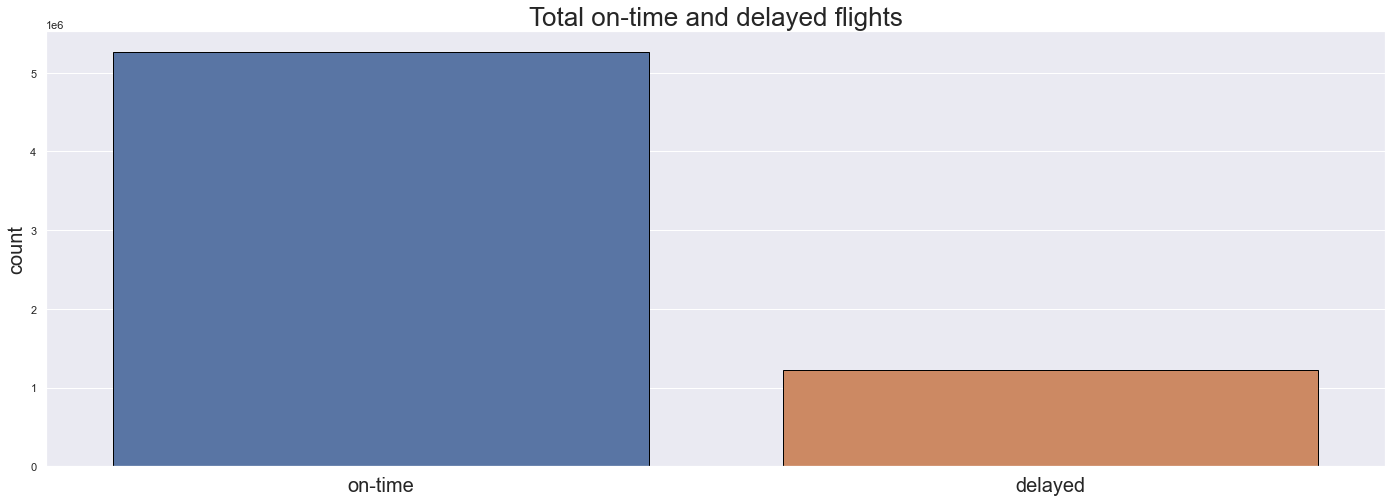

In [8]:
# Create a countplot of our target class
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="DEP_DEL15", edgecolor='black', data=df)
ax.set_xticks([0, 1], ["on-time", "delayed"], size=20)
ax.set_ylabel("count", fontsize = 20)
ax.set_title("Total on-time and delayed flights", fontdict={'fontsize':26})
ax.set_xlabel(None)

# Print the proportion of each target 
class_targets = df.groupby(['DEP_DEL15']).size()
print(f"On-time flights in the dataset: {class_targets[0]/len(df)*100:.2f}%")
print(f"Delayed flights in the dataset: {class_targets[1]/len(df)*100:.2f}%")

There is a clear bias towards on-time flights, whose proportion is more than 4-times the proportion of delayed flights. This imbalance will need to be considered when we select our model.

**Mean and standard deviation of numeric features**

Next I will have a quick look at some descriptive statistics for numeric features to get a handle on where the averages are. It may be interesting to see where some differences exist for delayed flights, however we cannot say whether any differences are statistically significant without further analysis. 

First I will compute the mean and standard deviation for delayed flights:

In [9]:
# Select numeric features, exluding month and day of week
numeric = df[TARGET_CLASS + CONTINUOUS + DISCRETE]
numeric = numeric.loc[:, ~numeric.columns.isin(['MONTH', 'DAY_OF_WEEK'])]

# Select delayed flights only
delayed_numeric = numeric[numeric['DEP_DEL15'] == 1]

# Compute the mean and standard deviation for numeric features of delayed flights
print("DELAYED FLIGHTS:")
display(delayed_numeric.describe().loc[['mean', 'std']].applymap('{:.2f}'.format))

DELAYED FLIGHTS:


,DEP_DEL15,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,LATITUDE,LONGITUDE,PRCP,SNOW,SNWD,TMAX,AWND,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,PLANE_AGE
mean,1.00,0.00,0.00,36.71,-93.25,0.16,0.06,0.13,71.13,8.72,3.90,3.47,28.24,134.88,13174.01,63211.75,3579.94,1645375.69,7828102.68,11.62
std,0.00,0.00,0.00,5.25,16.81,0.43,0.49,0.86,19.24,3.78,2.38,1.77,21.30,46.48,8731.56,35100.32,4094.56,1095573.89,5043404.98,6.77


Next, I will compute the same for on-time flights:

In [10]:
# Select on-time flights only
ontime_numeric = numeric[numeric['DEP_DEL15'] == 0]

# Compute the mean and standard deviation for numeric features of on-time flights
print("ON-TIME FLIGHTS:")
display(ontime_numeric.describe().loc[['mean', 'std']].applymap('{:.2f}'.format))

ON-TIME FLIGHTS:


,DEP_DEL15,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,LATITUDE,LONGITUDE,PRCP,SNOW,SNWD,TMAX,AWND,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,PLANE_AGE
mean,0.00,0.00,0.00,36.70,-94.49,0.09,0.02,0.08,71.55,8.25,3.80,2.95,27.74,133.47,12570.41,62901.99,3431.10,1575403.75,7811906.61,11.51
std,0.00,0.00,0.00,5.56,18.15,0.32,0.26,0.69,18.14,3.56,2.38,1.74,21.56,46.44,8860.97,34212.30,4286.35,1129931.10,5047687.73,6.97


The average daily percipitation and snow (`PRCP`, `SNOW`; in inches) is lower for on-time flights, but both feature means have a relatively large variance. There is a difference between the average monthly passengers at the airport (`AVG_MONTHLY_PASS_AIRPORT`), which is larger for delayed flights.

**Correlation matrix**

A correlation matrix is a collection of correlation coefficients between features in a dataset. This is useful because it can identify strong positive or negative linear relationships between features. If a pair of features have a very strong linear relationship, then they may be redundant; that is, one can be substituted for the other. 

In this section, I will pair numeric features and then create a correlation matrix. Using the correlation matrix, I will identify which features are highly correlated and then remove redundant features using a simple heuristic: If two features have $|\rho| >= 0.90$, I will remove the feature with a lower correlation to our target class.

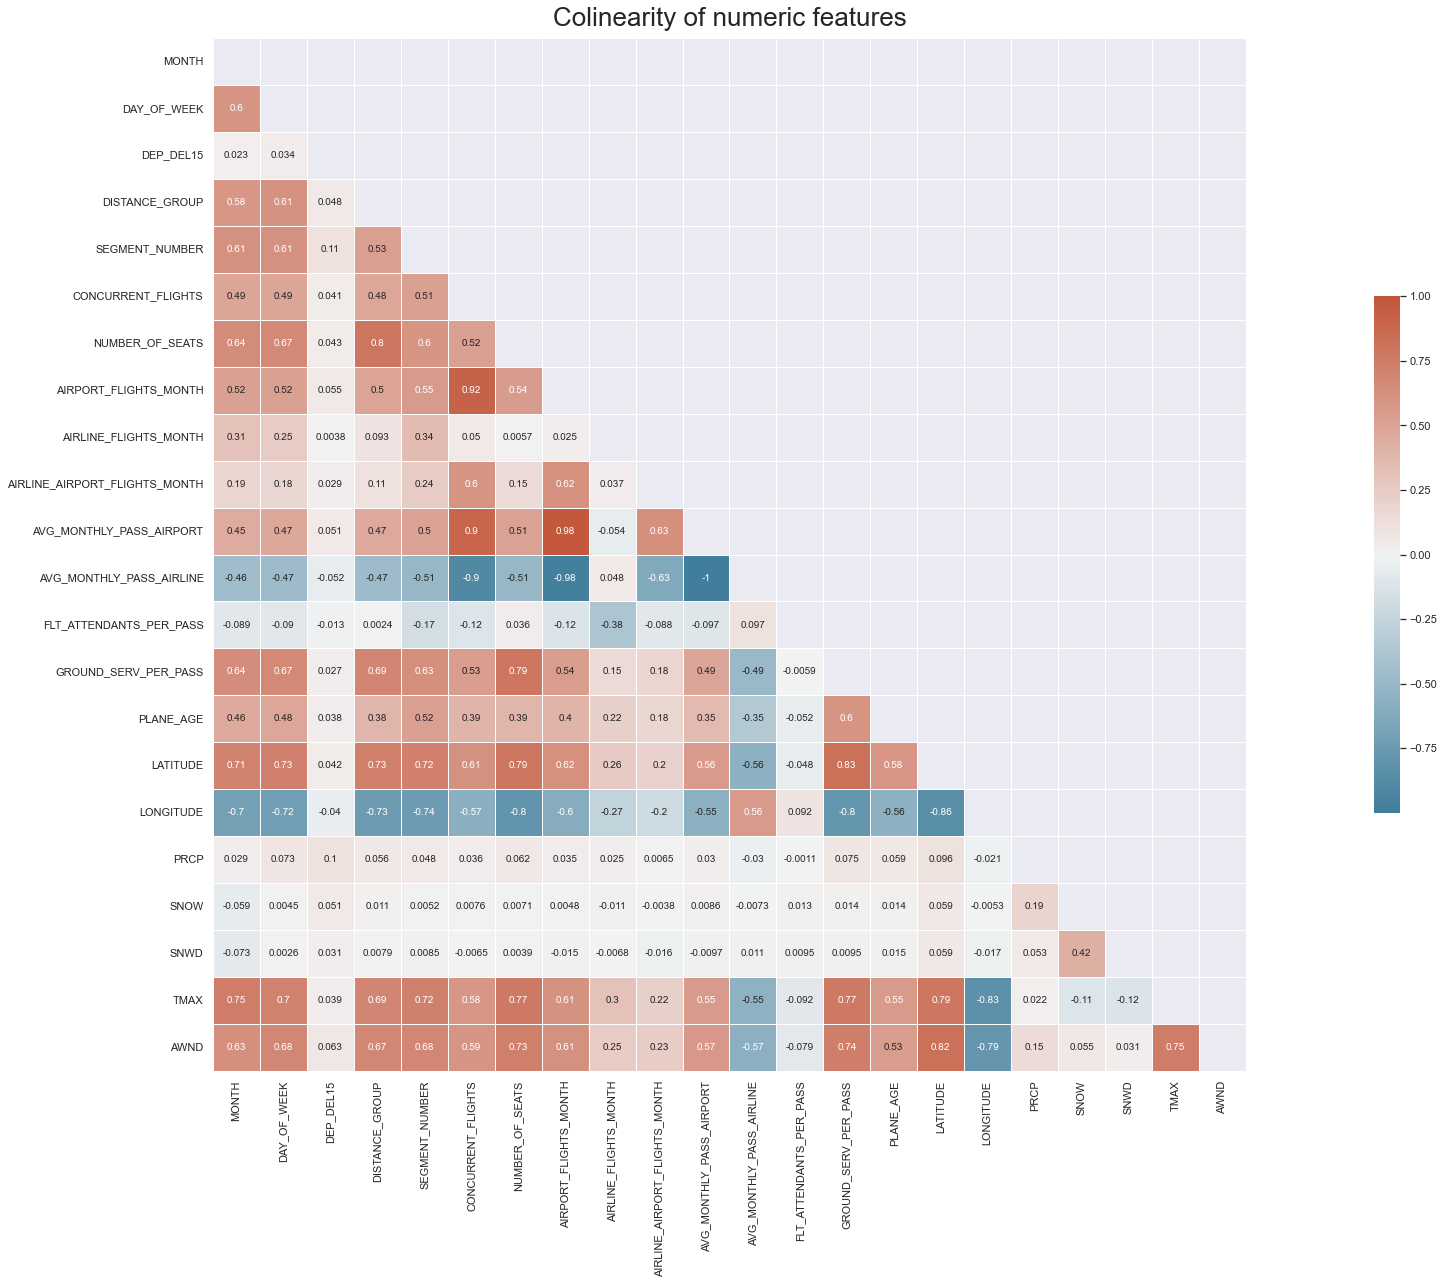

In [11]:
# Seaborn heatmap reference: 
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html

# Select only the numeric features from the dataset
numeric_features_df = df.select_dtypes(['int32', 'float64'])

# Normalize and then compute a pairwise correlation of numeric columns
normalized_pd = pd.DataFrame(Normalizer().fit_transform(numeric_features_df), columns = numeric_features_df.columns)
corr = normalized_pd.corr('spearman')

# Mask the upper triangle of the heatmap and create a diverging colormap
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Create the heatmap
f, ax = plt.subplots(figsize=(46, 19))
corr_heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, 
                           linewidths=.5, cbar_kws={"shrink": .5}, annot=True, 
                           annot_kws={"fontsize":10})

# Set the heatmap title
corr_heatmap.set_title('Colinearity of numeric features', fontdict={'fontsize':26}, pad=12);

The heatmap shows some highly correlated numeric features. For example, the average airport flights per month (`AIRPORT_FLIGHTS_MONTH`) is highly correlated with the average airport departing passengers per month (`AVG_MONTHLY_PASS_AIRPORT`), which we may expect.

The following algorithm should target and remove highly correlated features from the dataset using the heuristic above.

In [12]:
# Select the upper triangle of correlation matrix using our mask
corr_matrix = corr.where(cond=mask)

# Remove redundant features according to heuristic:
# If |p| >= 0.90 remove the feature less correlated to target class 'DEP_DEL15'
redundant_features = []
for col in corr_matrix:
    current_column = corr_matrix[col]       # Iterate over columns in the correlation matrix
    if current_column.name == 'DEP_DEL15':  # Ignore our target class
        continue
    else:
        for row in current_column.index:    # Select each row in the current column
            if current_column.name == row:  # Ignore correlation between the same row and column
                continue
            if np.abs(current_column[row]) >= 0.90:                  # Select highly correlated |p|>=0.90 features
                target_class_row = corr_matrix.loc['DEP_DEL15'][row] # Check the correlation with our target class
                target_class_col = corr_matrix.loc['DEP_DEL15'][col]
                if target_class_row >= target_class_col:             # Remove feature with lower correlation to target
                    redundant_features.append(current_column.name)
                else:
                    redundant_features.append(row)

# Print and drop redundant features
df.drop(set(redundant_features), axis=1, inplace=True)
print(f"Dropped redundant features:\n{set(redundant_features)}")

Dropped redundant features:
{'CONCURRENT_FLIGHTS', 'AVG_MONTHLY_PASS_AIRLINE', 'AVG_MONTHLY_PASS_AIRPORT'}


**Flight delays by month and weekday**

In this section, I will be investigating how delays vary over months and days of the week. My intuition tells me that holiday months and Mondays should have a higher incidence of delays due to more congestion at the airport.

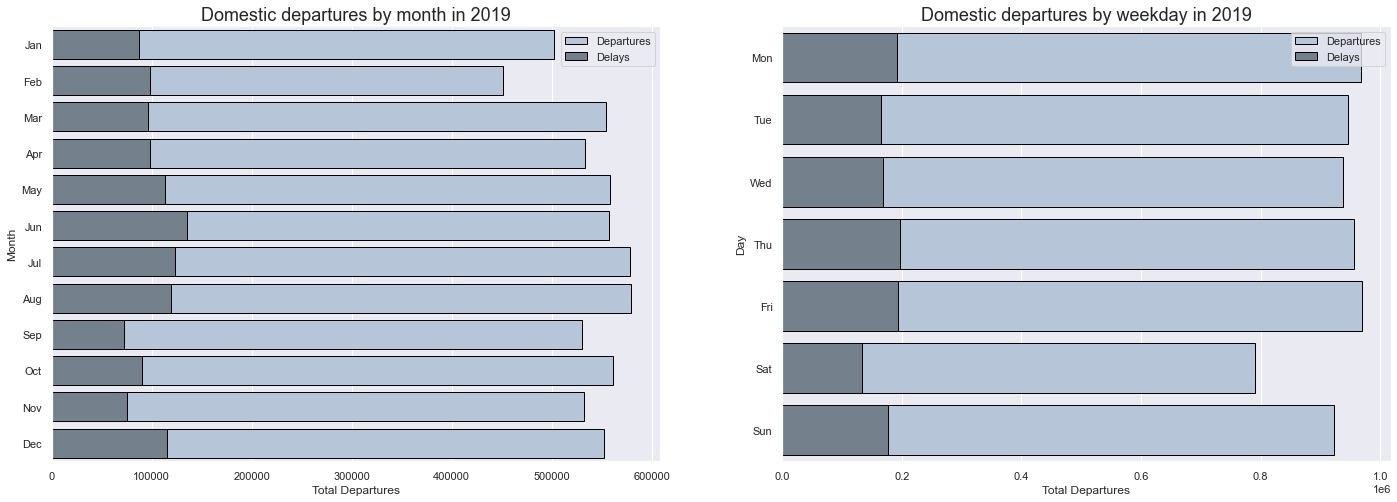

In [13]:
# Create dataframes to organize and sort the frequency data
month_df = pd.DataFrame({
    'MONTHLY_TOTAL'  :  df.groupby(['MONTH']).size(),
    'MONTHLY_DELAYS' :  df[df['DEP_DEL15'] == 1].groupby(['MONTH']).size(),
})
day_df = pd.DataFrame({
    'WEEKDAY_TOTAL'  :  df.groupby(['DAY_OF_WEEK']).size(),
    'WEEKDAY_DELAYS' :  df[df['DEP_DEL15'] == 1].groupby(['DAY_OF_WEEK']).size()
})

# Plot frequency of monthly delays
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.barplot(x="MONTHLY_TOTAL", y=month_df.index, data=month_df, ax=ax1, order=month_df.index, 
            edgecolor='black', color="lightsteelblue", label="Departures", orient="h")
sns.barplot(x="MONTHLY_DELAYS", y=month_df.index, data=month_df, ax=ax1, order=month_df.index, 
            edgecolor='black', color="slategray", label="Delays", orient="h")

# Plot frequency of week day delays
sns.barplot(x="WEEKDAY_TOTAL", y=day_df.index, data=day_df, ax=ax2, order=day_df.index, 
            edgecolor='black', color="lightsteelblue", label="Departures", orient="h")
sns.barplot(x="WEEKDAY_DELAYS", y=day_df.index, data=day_df, ax=ax2, order=day_df.index, 
            edgecolor='black', color="slategray", label="Delays", orient="h")

# Configure plot labels
ax1.set_title('Domestic departures by month in 2019', fontdict={'fontsize':18})
ax2.set_title('Domestic departures by weekday in 2019', fontdict={'fontsize':18})
ax1.set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax2.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax1.legend(ncol=1, loc="upper right", frameon=True), ax2.legend(ncol=1, loc="upper right", frameon=True)
ax1.set_xlabel("Total Departures"), ax1.set_ylabel("Month")
ax2.set_xlabel("Total Departures"), ax2.set_ylabel("Day");

The month of August has the most departures, followed by July. The fewest departures occur on Saturday's. The largest number of delays occur on June and on Thursday. However, the all days of the week appear to have a comparable number of delays relative to their total departures. 

**Distribution of plane age**

Next I will investigate whether delayed flights involve more older planes. In order to do this, I will plot the relative frequency of planes by age for both delayed and on-time flights.

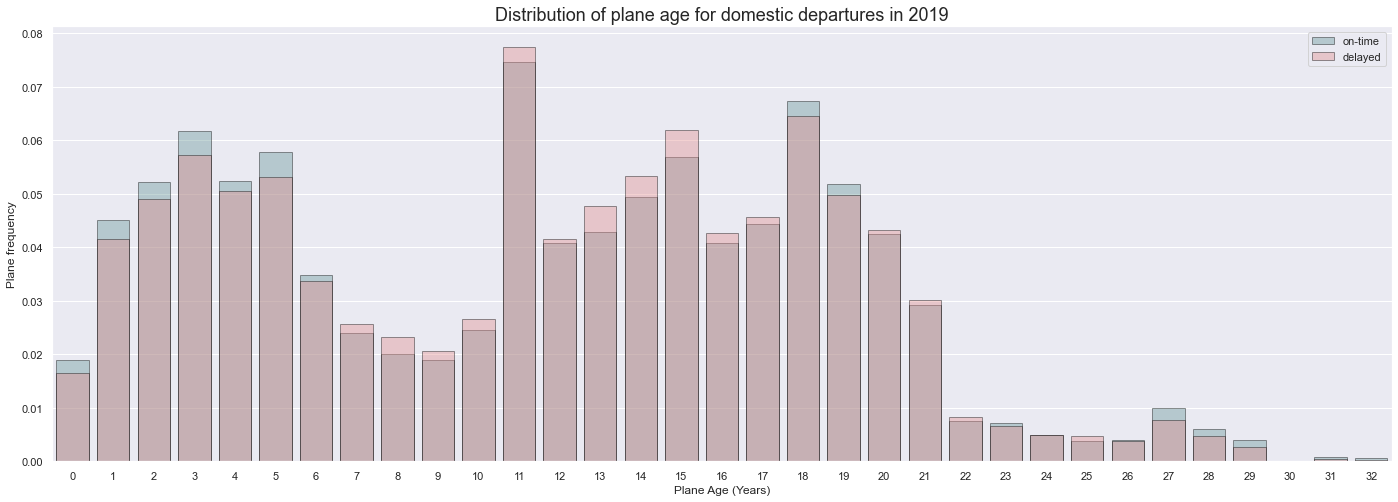

In [14]:
# Select delayed and ontime departures and sort by plane age
ontime_df = df[df['DEP_DEL15'] == 0].sort_values(['PLANE_AGE'], ascending=True)
delay_df = df[df['DEP_DEL15'] == 1].sort_values(['PLANE_AGE'], ascending=True)

# Compute the relative frequency of planes for each age group
ontime_df['AGE_PCT'] = ontime_df['PLANE_AGE'].map(ontime_df['PLANE_AGE'].value_counts(normalize=True))
delay_df['AGE_PCT'] = delay_df['PLANE_AGE'].map(delay_df['PLANE_AGE'].value_counts(normalize=True))

# Pair the age percentage with each unique plane age
ontime_df = ontime_df.groupby(['PLANE_AGE']).head(n=1)[['PLANE_AGE', 'AGE_PCT']]
delay_df = delay_df.groupby(['PLANE_AGE']).head(n=1)[['PLANE_AGE', 'AGE_PCT']]

# Plot the percentage of planes in each age group for delayed and on-time flights
ax = plt.subplots()
ax = sns.barplot(x=ontime_df.PLANE_AGE,y=ontime_df.AGE_PCT,color='cadetblue',edgecolor='black',label='on-time',alpha=0.4)
ax = sns.barplot(x=delay_df.PLANE_AGE,y=delay_df.AGE_PCT,color='lightcoral',edgecolor='black',label='delayed',alpha=0.4)
ax.set_title('Distribution of plane age for domestic departures in 2019', fontdict={'fontsize':18})
ax.set_xlabel("Plane Age (Years)"), ax.set_ylabel("Plane frequency")
plt.legend();

The difference between on-time and delayed departures appears to be quite small. The left hand side of the graph suggests that on-time flights use younger aircraft slightly more frequently. The middle of the graph suggests that delayed flights use older aircraft slightly more frequently.

**Distribution of delays across airlines**

Next I will plot the distribution of delays across different airlines to see if there are any particular carriers that are better or worse at avoiding delays.

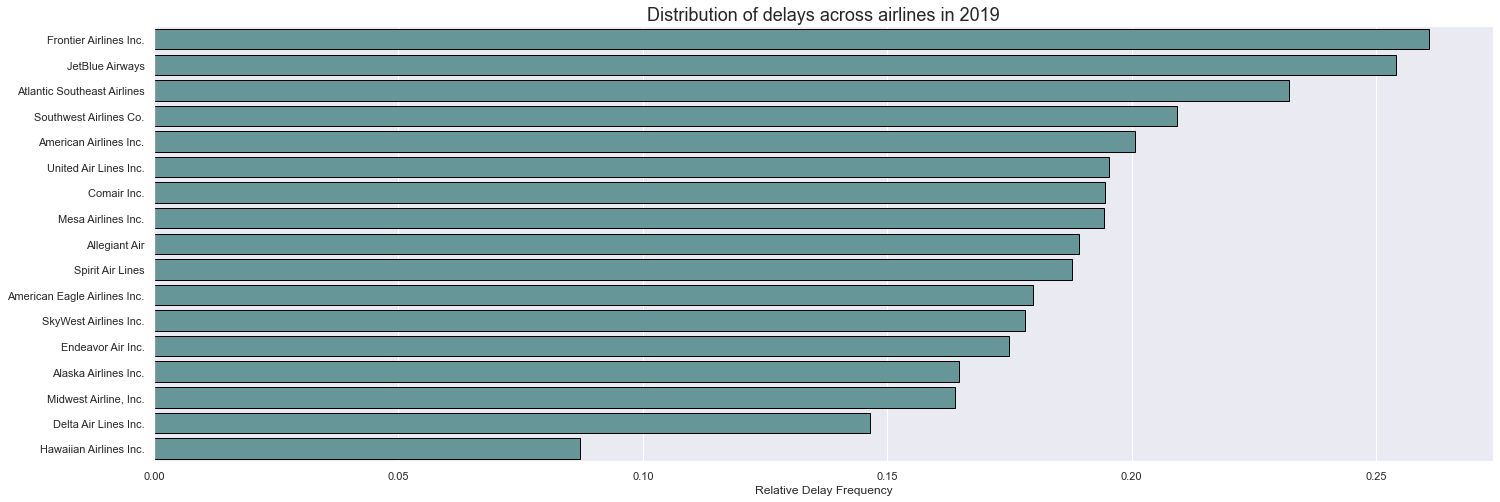

In [15]:
# Select departures grouped by CARRIER_NAME then compute the relative frequency of delays
delay_df = df.groupby(['CARRIER_NAME'])['DEP_DEL15'].value_counts(normalize=True).sort_values(ascending=False)

# Select only delayed flights
delay_df = delay_df.iloc[delay_df.index.get_level_values('DEP_DEL15') == 1]

# Get x and y axis from the delay_df series
x = delay_df.values
y = delay_df.index.get_level_values('CARRIER_NAME')

# Plot the distribution of delays
ax = plt.subplots()
ax = sns.barplot(x=x,y=y,color='cadetblue', edgecolor='black', orient="h")
ax.set_title('Distribution of delays across airlines in 2019', fontdict={'fontsize':18})
ax.set_xlabel("Relative Delay Frequency"), ax.set_ylabel("");

The clear winner here is Hawaiin Airlines which has the lowest relative delay frequency. The top two airlines are Frontier and Jetblue. I find this a little amusing because I often booked Frontier for flights to CU Boulder and I often encountered delays.

**Distribution of delays across departing airports**

This section is similar to the last, however instead of airline carriers I am plotting the relative frequency of delays over departing airports in the dataset. As with airline carrier, this should be interesting to see if there exist certain airports that are rife with delays. 

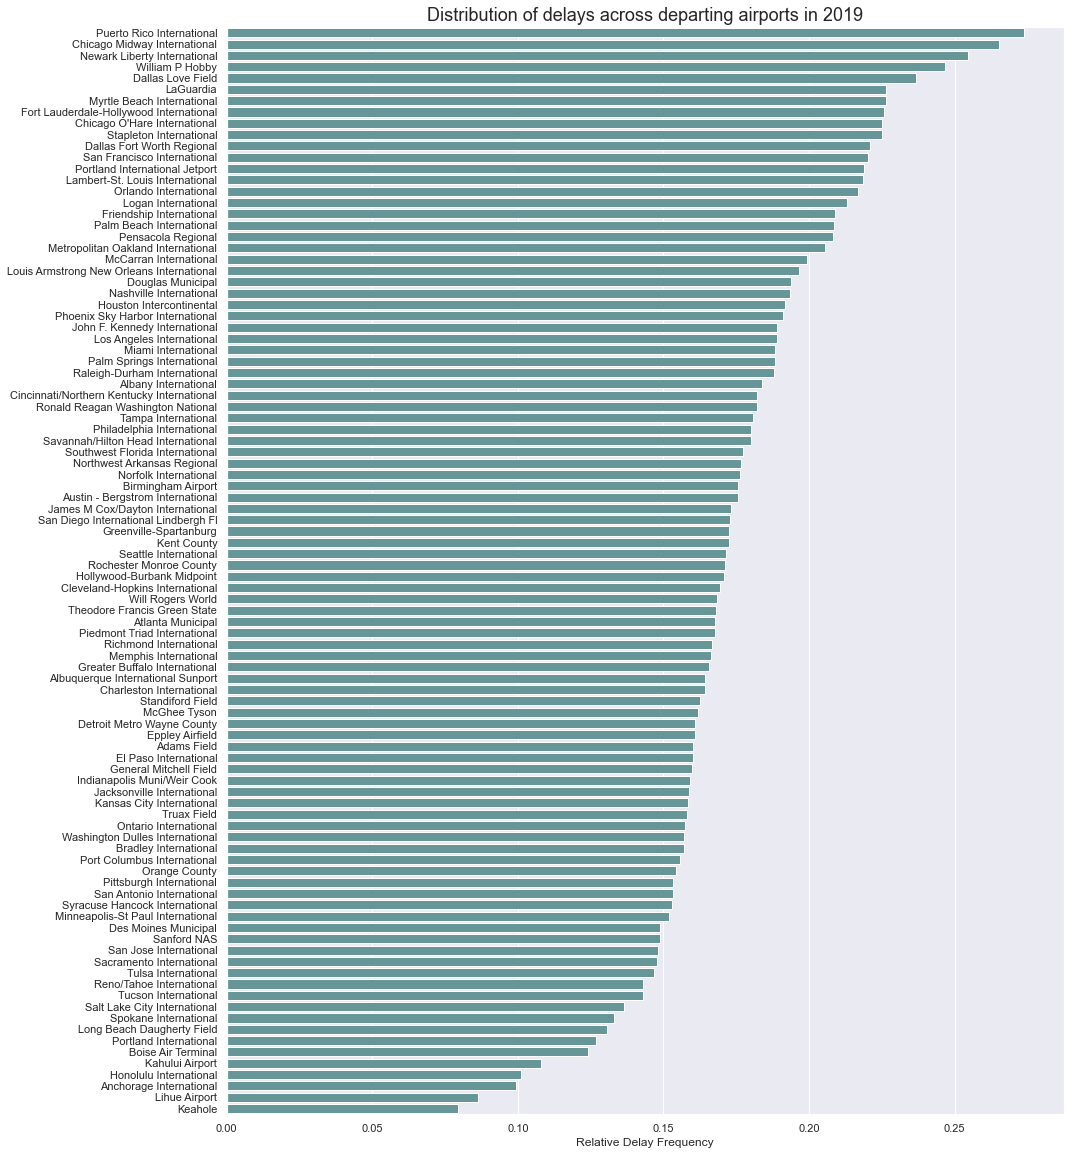

In [16]:
# Select departures grouped by DEPARTING_AIRPORT then compute the relative frequency of delays
delay_df = df.groupby(['DEPARTING_AIRPORT'])['DEP_DEL15'].value_counts(normalize=True).sort_values(ascending=False)

# Select only delayed flights
delay_df = delay_df.iloc[delay_df.index.get_level_values('DEP_DEL15') == 1]

# Get x and y axis from the delay_df series
x = delay_df.values
y = delay_df.index.get_level_values('DEPARTING_AIRPORT')

# Plot the distribution of delays
ax = plt.subplots(figsize=(15,20))
ax = sns.barplot(x=x,y=y,color='cadetblue', orient="h")
ax.set_title('Distribution of delays across departing airports in 2019', fontdict={'fontsize':18})
ax.set_xlabel("Relative Delay Frequency"), ax.set_ylabel("");

**Summary of EDA findings**

* The dataset is biased towards on-time flights.
* The largest number of departure delays occur on June and on Thursday.
* Airlines that are delayed most frequently are: Frontier and Jetblue.
* Airports with the most frequent delays are: Puerto Rico Intl., Chicago Midway, and Newark Liberty
* `SEGMENT_NUMBER` and `PRCP` have the largest positive correlation with target class `DEP_DEL15`.
* The numeric features `AVG_MONTHLY_PASS_AIRLINE`, `AVG_MONTHLY_PASS_AIRPORT`, `CONCURRENT_FLIGHTS` were dropped.


**Discussion of forseen difficulties**

EDA has identified foreseen difficulties to consider when selecting a model for this classification task:

1. The target class `DEP_DEL15` is imbalanced: 18.91% of the total flights in the dataset are delayed.
2. There remain an abundance of features after cleaning: 4 categorical, 18 numeric.
3. The dataset is large and may require algorithms with lower computational complexity.
4. Model input is heterogenous.

Each of these difficulties can be mitigated in different ways: 

1. Class imbalance in `DEP_DEL15` may be mitigated by sampling methods, such as oversampling delayed or undersampling on-time flights. 
2. Heterogenous input may require encoding categorical features, or selecting a model that can handle categorical and numeric features. 
3. Since the input size is quite large, it will be important to select models whose complexity has a lower polynomial $k$ of the input size $n$, i.e. $n^k$.

## Plans for Model Approach:

For this project, I intend to train two different models and then compare their accuracy. One will be relatively simple and the other will be more advanced. In both cases, I want to preserve interpretability because it could be interesting to see how each model weighs features differently.

**Model 1: Multivariate Logistic Regression**

The first classification algorithm that I plan to use is logistic regression. The reasons for this are:

1. Target class `DEP_DEL15` is categorical and binary which is well suited for logistic regression.

2. The algorithm is simple to run, resistant to overfitting, and can act as a starting point before attempting more advanced classification models.

3. The interpretability is high which allows us to better understand how the model predicts delays from the features.

4. It has favorable training time complexity $\mathcal{O}(n p)$ and test time complexity $\mathcal{O}(p)$ for the large input data $n$ and predictors $p$ in this dataset.

One important caveat with logistic regression is that real-world data isn't often modeled very well with a linear decision boundary. It's unlikely that flight delays are bounded by some linear combination of weather conditions, airline traffic, or airports.

Furthermore, logistic models perform poorly with highly correlated features. The correlation matrix in EDA did identify and remove some highly correlated features, but there remain features that are moderately correlated with $|\rho| >= 0.50$.

In light of these difficulties, I will relegate logistic regression as a first pass attempt at classifying flight delays. After training the model, I will asses the accuracy of its predictions and then see if a more advanced algorithm can achieve greater model accuracy.


**Model 2: Random Forest**

The second classification algorithm that I plan to use is the random forest ensemble method. The reasons for this are:

1. It handles non-linear parameters and is immune to highly correlated features, which are both improvements from the logistic model.

2. It can leverage the size of the dataset by generating larger bootstrapped sampling distributions with lower standard error.

3. As with logistic regression, interpretability of each decision tree is high and features can be ranked in terms of importance.

4. The training time complexity for $k$ trees, $n$ data points, and $p$ predictors is $\mathcal{O}(n\text{log}(n)pk)$ which is favorable for the large $n$ in this dataset.

The random forest model will require some parameter tuning and that could create some challenges due to the size of the dataset. For example, increasing the total number of trees and their depth might improve model accuracy, but it could create large increases in space and time complexity. 

**Handling class imbalance**

Both random forest and logistic regression will be sensitive to feature imbalances in the training data. This imbalance does exist. The target class `DEP_DEL15` labels 81.09% on-time flights and only 18.91% delayed flights, as was shown during EDA. If we were to train either model with a similarly imbalanced set of training data, the model could predict all flights as on-time and still be correct 81.09% of the time. Therefore, in both models, great care must be taken to balance the target class.

In the case of the logistic model, I will attempt to balance `DEP_DEL15` by using re-sampling methods, such as oversampling delayed flights or undersampling on-time flights. In the case of random forest, I can balance by using these re-sampling methods during the bootstrap step.

## Multivariate Logistic Regression:

__Feature Encoding__

I will begin by encoding the categorical variables as dummy variables which will be used during logistic regression. I will do this by using sklearn's `LabelEncoder` function which encodes categorical features as integer values between `0` and `n_classes-1` [[Source](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)].

In [17]:
def feature_encode(encoder, df, targets, **kwargs):
    """
    Encode or decode features within dataframe columns. 

    encoder(object):     Instantiated sklearn LabelEncoder() object.
    df(pd.DataFrame):    A pandas dataframe to be encoded or decoded.
    targets(list(str)):  List of dataframe columns to encode or decode.
    **kwargs(Bool):      Indicate whether to encode or decode.   

    Returns(pd.DataFrame):  Transformed dataframe with encoded or decoded columns.
    """
    # Copy the input dataframe to avoid mutation
    c_df = df.copy(deep=True)

    # Iterate over columns in the dataframe to be encoded or decoded
    for (col, _) in c_df.iteritems():
        if col in targets and kwargs.get('encode') == True:
            c_df[col] = encoder.transform(c_df[col])
        if col in targets and kwargs.get('decode') == True:
            c_df[col] = encoder.inverse_transform(c_df[col])
    return c_df

# Instantiate the label encoder and fit it to the categorical data
le = LabelEncoder()
le.fit(df[CATEGORICAL].stack().unique());

In order to demonstrate how this works, I will encode and decode some categorical features from `DEPARTING_AIRPORT` and then print the results:

In [18]:
# Encode categorical features and then print the first 5 unique encoded airports
encoded_df = feature_encode(encoder=le, df=df, targets=CATEGORICAL, encode=True)
print(f"\nEncoded airports:\n{encoded_df['DEPARTING_AIRPORT'].unique()[0:5]}")

# Decode categorical features and then print the first 5 unique decoded airports
decoded_df = feature_encode(encoder=le, df=encoded_df, targets=CATEGORICAL, decode=True)
print(f"\nDecoded airports:\n{decoded_df['DEPARTING_AIRPORT'].unique()[0:5]}")


Encoded airports:
[225 264  57 295 185]

Decoded airports:
['McCarran International' 'Orlando International' 'Boise Air Terminal'
 'Raleigh-Durham International' 'Kansas City International']


__Train-Test Split__

Next I will split the data into training and test sets using the sklearn method `train_test_split`. This function splits the dataset such that 75% goes to the training set and 25% goes to the test set. Random shuffling is also applied to the dataset before the split [[Source](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)].

In [19]:
# Select our dependent and independent variables
Y = encoded_df['DEP_DEL15']
X = encoded_df.loc[:, encoded_df.columns != 'DEP_DEL15']

# Split the dataset into training and test sets
logreg_X_train, logreg_X_test, logreg_Y_train, logreg_Y_test = train_test_split(X, Y, train_size=0.75, random_state=42)

__Target Class Balancing__

EDA indicated a large feature imbalance in the target class `DEP_DEL15`. In the dataset, only 18.91% of all departures are delayed while 81.09% are on time. I will now balance the target class in the training sets by oversampling the minority class with replacement.

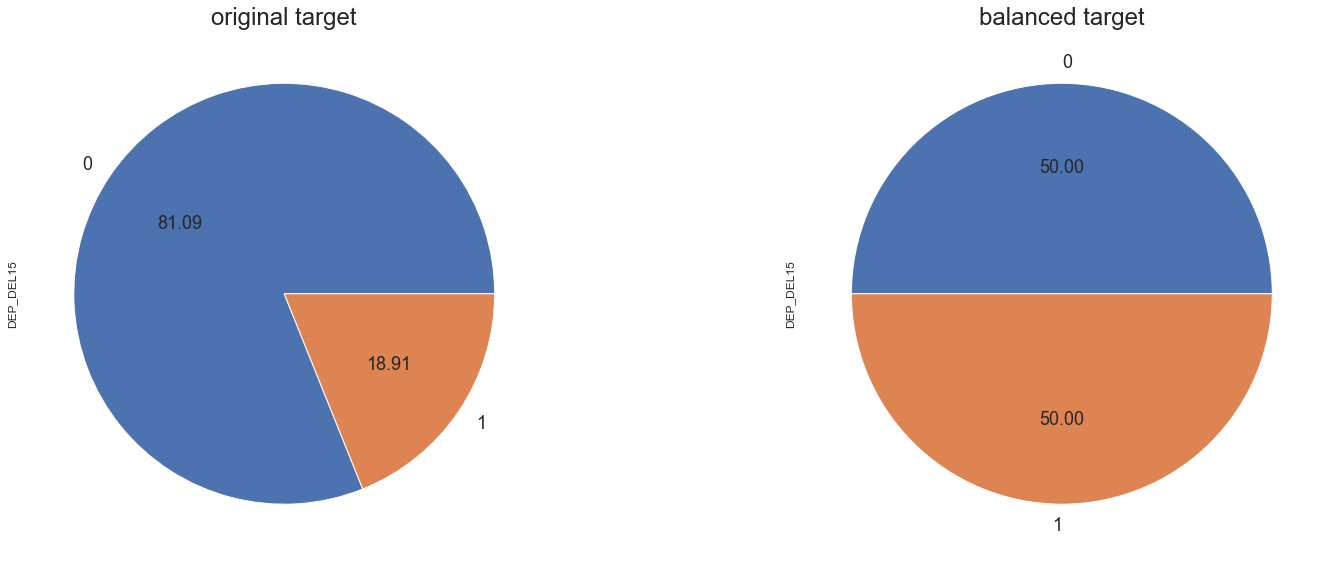

In [32]:
# Initialize random over sampler from the imbalanced-learn library
ros = RandomOverSampler(sampling_strategy='minority')

# Balance by oversampling the minority class in the training sets
ros_X_train, ros_Y_train = ros.fit_resample(logreg_X_train, logreg_Y_train)

# Plot the results
fig, ax = plt.subplots(ncols=2)
fig.patch.set_facecolor('white')
Y.value_counts().plot.pie(autopct="%.2f", ax=ax[0], textprops={'fontsize': 18})
ax[0].set_title("original target", fontdict={'fontsize':24})
ros_Y_train.value_counts().plot.pie(autopct="%.2f", ax=ax[1], textprops={'fontsize': 18})
ax[1].set_title("balanced target", fontdict={'fontsize':24})
plt.tight_layout();

__Feature Selection__

In class we covered best subset selection, but the time complexity is likely too high due to the abundance of features (p = 22) in this dataset. Furthermore, picking the best of the best features can risk overfitting. 

Since $n > p$ in this dataset, I decided to use a variant of backward stepwise selection called recursive feature elimination (RFE). This technique begins by fitting the training data to a linear regression model using all predictors. Each step removes a feature with the lowest importance.

In [23]:
# Run recursive feature elimination (RFE)
logreg = LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0.5)
rfe = RFE(estimator=logreg, step=1)
rfe = rfe.fit(ros_X_train, ros_Y_train)

# List the features selected as a boolean mask
mask = rfe.support_

# Select features for the training and test sets
ros_X_train = ros_X_train.iloc[:, mask]
logreg_X_test = logreg_X_test.iloc[:, mask]

# Print the results
print(f"Total Features:\n{list(X.columns)}\n")
print(f"RFE Feature Importance (1: high, 15: low):\n{rfe.ranking_}\n")
print(f"RFE Selected Features:\n{list(logreg_X_test.columns)}")

Total Features:
['MONTH', 'DAY_OF_WEEK', 'DEP_TIME_BLK', 'DISTANCE_GROUP', 'SEGMENT_NUMBER', 'NUMBER_OF_SEATS', 'CARRIER_NAME', 'AIRPORT_FLIGHTS_MONTH', 'AIRLINE_FLIGHTS_MONTH', 'AIRLINE_AIRPORT_FLIGHTS_MONTH', 'FLT_ATTENDANTS_PER_PASS', 'GROUND_SERV_PER_PASS', 'PLANE_AGE', 'DEPARTING_AIRPORT', 'LATITUDE', 'LONGITUDE', 'PREVIOUS_AIRPORT', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND']

RFE Feature Importance (1: high, 15: low):
[ 1  1  1  1  1  3  4  9 10  8 12 11  1  6  5  1  7  1  1  1  2  1]

RFE Selected Features:
['MONTH', 'DAY_OF_WEEK', 'DEP_TIME_BLK', 'DISTANCE_GROUP', 'SEGMENT_NUMBER', 'PLANE_AGE', 'LONGITUDE', 'PRCP', 'SNOW', 'SNWD', 'AWND']


__Model Fitting__

I will now train a logistic regression model using the balanced training data and features selected from RFE, and then use the model to make predictions from the test data. The logistic regression classifier is initialized from the sklearn library [[Source](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.get_params)].

In [24]:
# Instantiate the logistic regression classifier and fit the training data
logreg = LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0.5)
logreg.fit(ros_X_train, ros_Y_train);

# Predict flight delays form the test set
logreg_Y_pred = logreg.predict(logreg_X_test)

## Random Forest:

The random forest classifier is a model that we have not covered in class. It is an ensemble method, which means it makes predictions by considering the predictions made by multiple models. In the case of random forest, these models are decision tree classifiers. 

The decision tree classifiers are constructed using bootstraped samples from the training dataset, and each tree consists of nodes and edges. The nodes correspond to features in the dataset, and the outgoing edges split depending on the conditions specified at each node. The features in each tree are randomly selected from a designated set number of features, and the splitting is determined by the gini impurity metric.

In an effort to illustrate what occurs when constructing decision trees using this dataset, I will fit the balanced training data to a random forest classifier with some small hyperparameters, and then select a single tree from the forest so that we can visualize it.

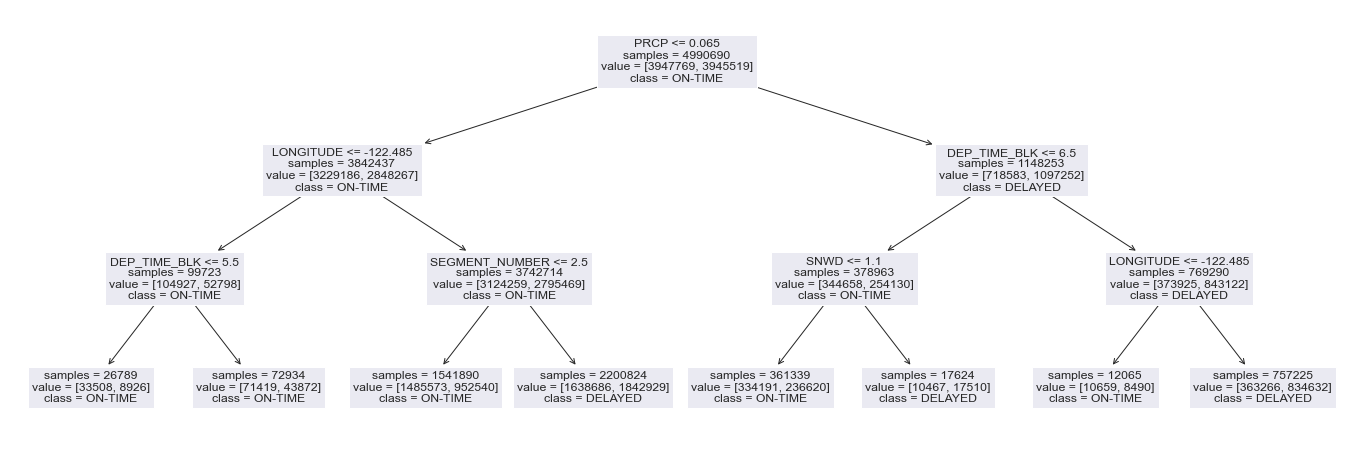

In [60]:
# Instantiate a demo random forest classifier and fit the training data
randomForestDemo = RandomForestClassifier(n_estimators=3, max_features=5, max_depth=3)
randomForestDemo.fit(ros_X_train, ros_Y_train)

# Extract single decision tree classifier from the forest
estimator = randomForestDemo.estimators_[2]
tree.plot_tree(estimator, class_names=["ON-TIME", "DELAYED"], impurity=False, feature_names=ros_X_train.columns);

When a new datapoint traverses the decision tree, it starts by checking the conditions specified by the root node and continues traversing the tree until it is labeled at a leaf node. In a random forest, multiple unique decision trees are created, which means a single data point will be classified multiple times. The final prediction made by the random forest is determined by the prediction made by the majority of decision trees in the forest.

__Feature Encoding, Train-Test Split, and Target Class Balancing__

I will begin by encoding the categorical features, splitting the dataset into training and test sets, and then balancing the target class:

In [43]:
# Instantiate the label encoder and fit it to the categorical data
le = LabelEncoder()
le.fit(df[CATEGORICAL].stack().unique());

# Encode categorical features and then print the first 5 unique encoded airports
encoded_df = feature_encode(encoder=le, df=df, targets=CATEGORICAL, encode=True)

# Select our dependent and independent variables
Y = encoded_df['DEP_DEL15']
X = encoded_df.loc[:, encoded_df.columns != 'DEP_DEL15']

# Split the dataset into training and test sets
forest_X_train, forest_X_test, forest_Y_train, forest_Y_test = train_test_split(X, Y, train_size=0.75, random_state=42)

# Initialize random over sampler from the imbalanced-learn library
ros = RandomOverSampler(sampling_strategy='minority')

# Balance by oversampling the minority class in the training sets
ros_X_train, ros_Y_train = ros.fit_resample(forest_X_train, forest_Y_train)

__Hyperparameter Tuning and K-Fold Cross Validation__

There are a number of hyperparameters in random forest classifiers which can be tuned to improve model performance. Some of these are:

1. Size of the bootstrap sample used to create the decision trees.


2. The number of randomly selected features in each tree. 


3. The depth of decision trees in the forest.

For brevity, I will investigate how tree depth affects model accuracy. Since the dataset is quite large, and I will be training many random forest models, I will use smaller sample sizes of $n \approx 100,000$ during tuning.

When assessing model performance during tuning, I will use k-fold cross validation. This partitions the training data into k sets (i.e. folds), one of which is set aside to evaluate the model. The model is trained and its accuracy is computed using the evaluation set. This process repeats until every fold has been used as the evaluation set. The score returned by `cross_val_score` is the average accuracy generated by each fold. 

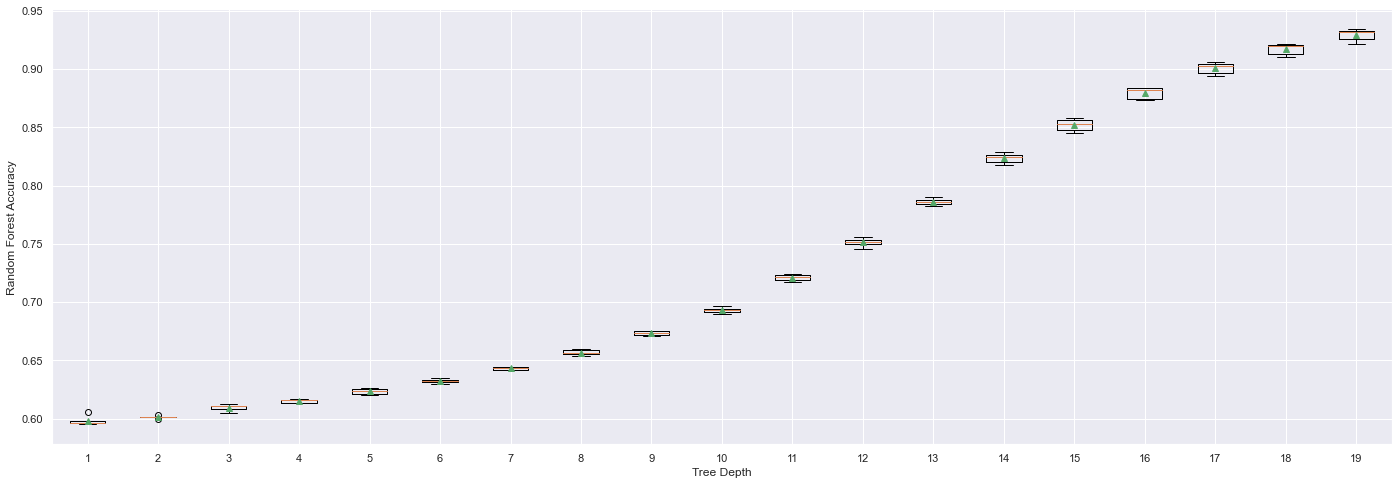

In [52]:
# Split and balance training and test sets for hyperparameter optimization of size n = 100,000
Xh_train, Xh_test, Yh_train, Yh_test = train_test_split(X, Y, train_size=0.01, random_state=42)
ros_Xh_train, ros_Yh_train = ros.fit_resample(Xh_train, Yh_train)

# Create random forest models using k=1 to k=10 tree depth
k_features, model_score = [], []
for i in range(1, 20):
    # Generate a random forest classifier with depth set to i
    randomForest = RandomForestClassifier(max_depth=i)

    # Compute 5-fold cross validation score
    score = cross_val_score(randomForest, ros_Xh_train, ros_Yh_train, scoring='accuracy', cv=5)

    # Record the model score and k features
    model_score.append(score)
    k_features.append(i)

# Plot the results
plt.boxplot(model_score, labels=k_features, showmeans=True)
plt.xlabel("Tree Depth")
plt.ylabel("Random Forest Accuracy");

This indicates that model performance increases as we increase tree depth, but there may be diminishing returns at approximately `max_depth=20`.

__Model Fitting__

Since a smaller subset of $n\approx100,000$ was used during tuning, the time complexity at `max_depth=20` may be too large when using the full training set, which contains several million data points. So, I will set tree depth to `max_depth=13` in an effort to improve performance while balancing time constraints.

In [56]:
%%time

# Instantiate the random forest classifier and fit the training data
randomForest = RandomForestClassifier(max_depth=13)
randomForest.fit(ros_X_train, ros_Y_train)

# Predict flight delays form the test set
forest_Y_pred = randomForest.predict(forest_X_test)

Wall time: 34min 18s


## Results and Analysis

Now that both models have been fitted to the training data, I will evaluate predictions made by each model using some performance metrics.

__Confusion matrix__

The confusion matrices below summarize the predictions made by each model. Since the target class is binary, each confusion matrix will be a 2x2 matrix with rows and columns that correspond to the state of the target class: on-time flight or delayed flight. The overlapping cells show the percentage of true positive, false positive, true negative, and false negative predictions.

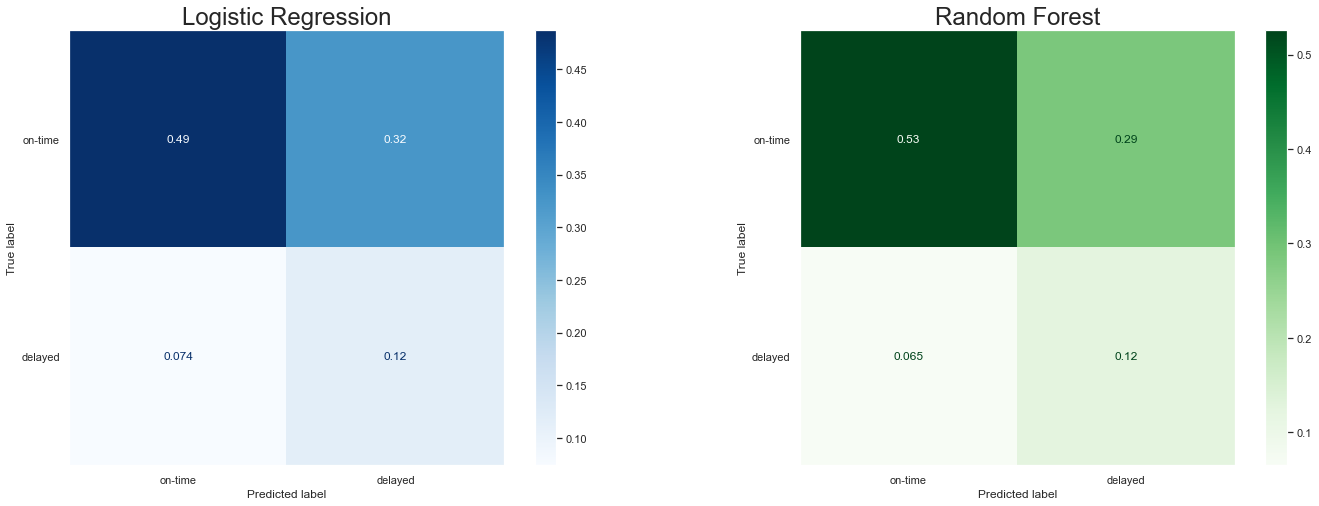

In [57]:
# Compute the log reg confusion matrix and create its visualization
logreg_cm = confusion_matrix(logreg_Y_test, logreg_Y_pred, normalize='all')
logreg_disp = ConfusionMatrixDisplay(logreg_cm, display_labels=['on-time','delayed'])

# Compute the random forest confusion matrix and create its visualization
forest_cm = confusion_matrix(forest_Y_test, forest_Y_pred, normalize='all')
forest_disp = ConfusionMatrixDisplay(forest_cm, display_labels=['on-time','delayed'])

# Display the confusion matrix
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].grid(False), ax[1].grid(False)
logreg_disp.plot(ax=ax[0], cmap='Blues')
forest_disp.plot(ax=ax[1], cmap='Greens')
ax[0].set_title("Logistic Regression", fontdict={'fontsize':24});
ax[1].set_title("Random Forest", fontdict={'fontsize':24});

Most predictions for both models are true positives (i.e. predicting a flight is on-time when it is actually on-time) at 0.49 for the logistic model and 0.53 for the random forest. Next largest is false negative (i.e. predicting a flight is delayed when it is actually on-time) which is 0.32 for the logistic regression model and 0.29 for the random forest. Both models have approximately the same percentage of true negatives.

__Performance Metrics__

Next I will evaluate each model by computing several classification performance metrics:

1. **Precision:** The model's ability to not predict a positive sample that is negative.

2. **Recall:** The model's ability to find all positive samples.

3. **F1 score:** The harmonic mean of precision and recall.

4. **Accuracy:** The percentage of correctly classified samples.

These performance metrics are computed using the sklearn `classification_report` function from the sklearn library [[Source](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)].

In [58]:
# Print precision, recall, F1 score, and accuracy performance metrics
print("=="*40+"\n\t\t\t\tLOGISTIC REGRESSION\n"+"=="*40)
print(classification_report(logreg_Y_test, logreg_Y_pred, target_names=['on-time', 'delayed']))

# Print precision, recall, F1 score, and accuracy performance metrics
print("=="*40+"\n\t\t\t\tRANDOM FOREST\n"+"=="*40)
print(classification_report(forest_Y_test, forest_Y_pred, target_names=['on-time', 'delayed']))

				LOGISTIC REGRESSION
              precision    recall  f1-score   support

     on-time       0.87      0.60      0.71   1315050
     delayed       0.26      0.61      0.37    307216

    accuracy                           0.60   1622266
   macro avg       0.57      0.60      0.54   1622266
weighted avg       0.75      0.60      0.64   1622266

				RANDOM FOREST
              precision    recall  f1-score   support

     on-time       0.89      0.65      0.75   1315050
     delayed       0.30      0.66      0.42    307216

    accuracy                           0.65   1622266
   macro avg       0.60      0.65      0.58   1622266
weighted avg       0.78      0.65      0.69   1622266



Each classifier is more precise at predicting on-time flights than delayed flights. This means that both models are fairly good at not misclassifying an on-time flight, which is good. Unfortunately, both models have a low precision for delayed flights. This means the models often missclassify a flight that is delayed when it is actually on-time.

The random forest model has a slightly higher recall than the logistic regression model, which means it is more likely to find on-time flights among false negatives. The F1 score for the random forest model is also slightly larger than the logistic regression model when predicting both on-time and delayed flights. This supports the assertion that the random forest model is an improvement over the logistic regression model.

__ROC Curve__

Lastly, I will plot a receiver operating characteristic (ROC) curve which will be used to compare the performance of the two classification models. The ROC plots the rate of true positives as a function of the false positive rate. A model that makes good predictions would have a ROC curve towards the top left corner of the graph, which would indicate a higher true positive rate and lower false positive rate. 

I will also compute the area under the curve (AUC) for the purposes of quantifying the results of the ROC curve. A model with good performance will have a ROC curve with a higher true positive rate and lower false positive rate, and this would result in a larger AUC.

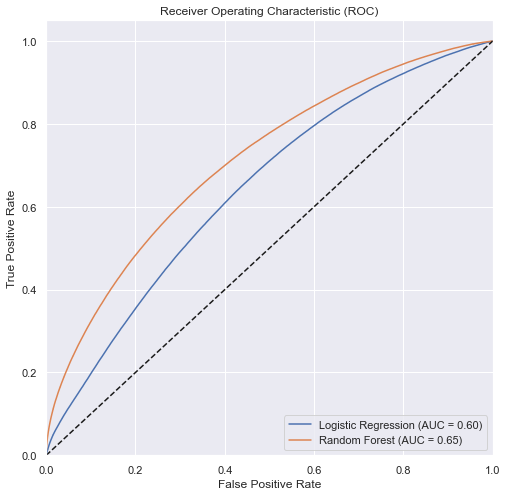

In [66]:
# Compute the AUC for both models
logreg_auc = roc_auc_score(logreg_Y_test, logreg_Y_pred)
forest_auc = roc_auc_score(forest_Y_test, forest_Y_pred)

# Compute ROC Curves
log_fpr, log_tpr, _ = roc_curve(logreg_Y_test, logreg.predict_proba(logreg_X_test)[:,1])
tree_fpr, tree_tpr, _ = roc_curve(forest_Y_test, randomForest.predict_proba(forest_X_test)[:,1])

# Plot settings
plt.figure(figsize=(8,8))
plt.plot(log_fpr, log_tpr, label='Logistic Regression (AUC = %0.2f)'%logreg_auc)
plt.plot(tree_fpr, tree_tpr, label='Random Forest (AUC = %0.2f)'%forest_auc)
plt.plot([0,1],[0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Receiver Operating Characteristic (ROC)')
plt.show()

The ROC curve indicates that the random forest performs slightly better than the logistic regression model. This is reflected by the larger AUC of 0.65 for the random forest model compared to the 0.60 AUC of the logistic regression model.

## Discussion and Conclusion:

Although the performance metrics indicate that the random forest classifier is an improvement over the logistic regression classifier, in general both models struggled at classifying flight delays. In this last section, I will summarize the performance of each model and discuss some improvements.

__Summary of Results__

1. The models are far more precise at classifying on-time flights than delayed flights.
    * Precision for on-time flights is 0.87 for logistic regression and 0.89 for random forest.

    * Precision for delayed flights is 0.26 for logistic regression and 0.30 for random forest.

2. Both models have a relatively high rate of false positives.
    * 32% of on-time flights are incorrectly classified as delayed by the logistic regression model.
    
    * 29% of on-time flights are incorrectly classified as delayed by the random forest mode.

3. Both models have a low false negative rate.

    * 7.4% of delayed flights are incorrectly classified as on-time by the logistic regression model.
    
    * 6.5% of delayed flights are incorrectly classified as on-time by the random forest model.

4. Overall, the random forest model is a slight improvement over the logistic regression model. 

    * The random forest model has slightly greater F1 score than the logistic regression model.

    * The random forest model has a slightly higher ROC AUC of 0.65 than the logistic regression ROC AUC of 0.6.

__Discussion and Improvements:__

There are additional hyperparameters that could be tuned to potentially gain some performance improvements. In the logistic regression model, recursive feature elimination (RFE) selected 10 features with the highest importance. The model might perform better with more. Additionally, the estimator of feature importance is itself a logistic regression model. There may be other supervised learning models that are better estimators.

The size of the dataset also created some challenges that affected model performance. In the absence of parallelization, working with millions of data points put a soft cap on what I could compute. For example, SMOTE may have balanced the target class better by producing synthetic data points. Since this was too computationally intensive due to the size of the dataset and the number of features, I had to settle with random oversampling which repeated a lot of values in the minority class. 

Lastly, this classification problem assumes that flight delays, under certain conditions, are either on time or not. However, there are many instances where flights depart on time in spite of harsh weather conditions and airport congestion. There are also instances where the reverse is true. In these cases, perhaps a better model for flight delays would be a regression model that generates a continuous value, such as a continuous probability of a delay, rather than a discrete class label.